In [1]:
!pip uninstall --yes allennlp
!pip uninstall --yes transformers
!pip install git+https://github.com/huggingface/transformers.git

Found existing installation: allennlp 2.10.1
Uninstalling allennlp-2.10.1:
  Successfully uninstalled allennlp-2.10.1
Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-3_0af33c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-3_0af33c
  Resolved https://github.com/huggingface/transformers.git to commit 49ab16239c74ccfca2298472868caadb1d2c3878
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6614757 sha256=3c70a0fd5a83d7fd5c9e6ee181e06f49d27fb49a929df081c18b59faedaa01af
  Stored in directory: /tmp

In [2]:
# !pip install decord

In [3]:
import os
import cv2
from PIL import Image

from tqdm import tqdm
from tqdm.contrib import tzip
import wandb

import pickle

import nltk

## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

# read video function

In [4]:
def image_sum(imgs):
    blended1 = Image.blend(imgs[0], imgs[1], alpha=0.5)
    blended2 = Image.blend(imgs[2], imgs[3], alpha=0.5)
    blended = Image.blend(blended1, blended2, alpha=0.5)
    return blended

In [5]:
def image_grid(imgs, rows, cols):
    pils = imgs
    
    assert len(imgs) == rows*cols
#     print(imgs[0].size)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
def read_video(path, transform=None, frames_num=4, window=30):
    frames = []
    cap = cv2.VideoCapture(path)
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length//(frames_num)
    current_frame = 0
    for i in range(length):

        ret, frame = cap.read(current_frame)

        if ret and i==current_frame and len(frames)<frames_num:
            size = 112, 112
            frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frame.thumbnail(size, Image.ANTIALIAS)
            frames.append(frame)
            current_frame += N
        
    cap.release()
    #print(frames)
    return frames

In [7]:
# # import numpy as np
# # from decord import VideoReader, cpu

# def sample_frames(path, frames_num):
#     # set seed for reproducability
#     np.random.seed(45)

#     def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
#         converted_len = int(clip_len * frame_sample_rate)
#         end_idx = np.random.randint(converted_len, seg_len)
#         start_idx = end_idx - converted_len
#         indices = np.linspace(start_idx, end_idx, num=clip_len)
#         indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
#         return indices

#     # video clip consists of 300 frames (10 seconds at 30 FPS)
#     videoreader = VideoReader(path, num_threads=1, ctx=cpu(0))

#     # sample 6 frames
#     videoreader.seek(0)
#     indices = sample_frame_indices(clip_len=frames_num, frame_sample_rate=4, seg_len=len(videoreader))
#     frames = videoreader.get_batch(indices)
#     print(frames.shape)

#     return list(frames)

# frames = sample_frames(file_path, num_frames)

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values. 

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [8]:
from torch.utils.data import Dataset
from tqdm.contrib import tzip

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, video_path, processor):
        self.processor = processor
        self.dataset = []
        
        for caption, video_name in tzip(dataset.caption, dataset.paths):
            name = f'{video_path}/{video_name}'
            if os.path.exists(name):
                video = read_video(path=name, frames_num=4)
                image = image_grid(video,2,2)
                self.dataset.append({'image': image,
                                     'text': caption})

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [9]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [10]:
import pandas as pd

train_df = pd.read_csv('/kaggle/input/nto-splitted-data/train.csv')
test_df = pd.read_csv('/kaggle/input/nto-splitted-data/test.csv')

video_path = '/kaggle/input/nto-hack-video/videos_train'

In [11]:
train_dataset = ImageCaptioningDataset(train_df, video_path, processor)

  0%|          | 0/4520 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  app.launch_new_instance()


In [12]:
test_dataset = ImageCaptioningDataset(test_df, video_path, processor)

  0%|          | 0/1131 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  app.launch_new_instance()


In [ ]:
'dsfds'

In [13]:
out_path = f"test_dataset.pkl"
with open(out_path, 'wb') as f:
    pickle.dump({"test_dataset": test_dataset}, f)

print('Done')
print("%0d embeddings saved " % len(test_dataset))

Done
1131 embeddings saved 


In [14]:
out_path = f"train_dataset.pkl"
with open(out_path, 'wb') as f:
    pickle.dump({"train_dataset": train_dataset}, f)

print('Done')
print("%0d embeddings saved " % len(train_dataset))

Done
4520 embeddings saved 


Let's check one example of the dataset:

In [13]:
len(train_dataset), len(test_dataset)

(4520, 1131)

In [14]:
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])



input_ids torch.Size([512])

attention_mask torch.Size([512])

pixel_values torch.Size([3, 224, 224])

## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([10, 512])
attention_mask torch.Size([10, 512])
pixel_values torch.Size([10, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [17]:
def all_replaces(text):
    return text.replace('[CLS]', '').replace('[SEP]', '').replace('[PAD]', '').strip()

In [18]:
all_replaces(processor.decode(batch["input_ids"][0]))

'kitten playing with a ball at home'

We can "denormalize" the pixel values to get back an image:

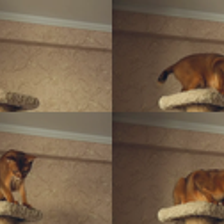

In [19]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [4]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [5]:
model

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0): GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_pr

In [21]:
for param in model.git.image_encoder.parameters():
    param.requires_grad = False
#     print(param)

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [22]:
# outputs = model(input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 pixel_values=batch["pixel_values"],
#                 labels=batch["input_ids"])
# outputs.loss

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [23]:
os.environ["WANDB_API_KEY"] = '416fa5ea55703d6fcbc4550f4fc08c7d5b672a86'

In [24]:
wandb.init(project="GIT", name='froze')

wandb: Currently logged in as: vanyamironov. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
import torch
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [26]:

torch.manual_seed(0)


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(15):
    train_loss = []
    print(f'epoch: ', epoch)
    progress = tqdm(total=len(train_dataloader), desc='')
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        progress.set_postfix({"loss": loss.item()})
        progress.update()
        
        train_loss += [loss.item()]
        
        del outputs
        torch.clear_autocast_cache()
        torch.cuda.empty_cache()
    
    test_loss = []
    test_metric = []
    model.eval()
    progress.close()
    
    progress1 = tqdm(total=len(test_dataloader), desc='')
    for idx, batch in enumerate(test_dataloader):
        
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
            
        loss = outputs.loss
        test_loss.append(loss)
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        y = all_replaces(processor.decode(input_ids[0]))
        score = nltk.translate.bleu_score.sentence_bleu([y], generated_caption)
        test_metric += [score]
        
        progress1.set_postfix({"bleu": sum(test_metric) / len(test_metric)})
        progress1.update()
        
    model.train()
    progress1.close()
        
    wandb.log({'bleu': sum(test_metric) / len(test_metric),
               "test_loss":  sum(test_loss) / len(test_dataloader),
               "train_loss":  sum(train_loss) / len(train_dataloader)})
#     print({'bleu': sum(test_metric) / len(test_metric),
#                "test_loss":  sum(test_loss) / len(test_dataloader),
#                "train_loss":  sum(train_loss) / len(train_dataloader)})

epoch:  0


  0%|          | 5/1131 [00:01<05:10,  3.63it/s, bleu=0.223]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  4%|▍         | 47/1131 [00:09<04:23,  4.11it/s, bleu=0.203]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 13%|█▎        | 148/1131 [00:29<02:39,  6.15it/s, bleu=0.207]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore

epoch:  1


  8%|▊         | 35/452 [00:29<05:39,  1.23it/s, loss=0.431]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1131/1131 [03:40<00:00,  5.13it/s, bleu=0.217]


epoch:  2


100%|██████████| 1131/1131 [03:40<00:00,  5.12it/s, bleu=0.228]


epoch:  3


100%|██████████| 1131/1131 [03:51<00:00,  4.89it/s, bleu=0.227]


epoch:  4


 53%|█████▎    | 596/1131 [02:10<01:34,  5.64it/s, bleu=0.241]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1131/1131 [03:51<00:00,  4.89it/s, bleu=0.24] 


epoch:  6


  4%|▍         | 50/1131 [00:10<02:50,  6.33it/s, bleu=0.261]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1131/1131 [04:17<00:00,  4.39it/s, bleu=0.247]


epoch:  8


100%|██████████| 1131/1131 [04:12<00:00,  4.48it/s, bleu=0.251]


epoch:  9


100%|██████████| 1131/1131 [04:16<00:00,  4.41it/s, bleu=0.253]


epoch:  10


100%|██████████| 1131/1131 [04:01<00:00,  4.69it/s, bleu=0.247]


epoch:  11


100%|██████████| 1131/1131 [04:18<00:00,  4.37it/s, bleu=0.253]


epoch:  12


100%|██████████| 1131/1131 [04:17<00:00,  4.39it/s, bleu=0.257]


epoch:  13


100%|██████████| 1131/1131 [04:05<00:00,  4.62it/s, bleu=0.249]


epoch:  14


100%|██████████| 1131/1131 [04:12<00:00,  4.48it/s, bleu=0.255]


In [ ]:
all_replaces(processor.decode(input_ids[0]))
# input_ids[0]

In [27]:
'ssdfsdf'

'ssdfsdf'

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

In [1]:
batch = next(iter(train_dataloader))

NameError: name 'train_dataloader' is not defined

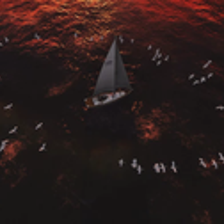

In [45]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [46]:
# prepare image for the model
inputs = processor(images=unnormalized_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

flying over the sea


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.